# Learning Pandas using Enigma.io's API and datasets.


##This notebook uses Pandas to explore datasets exported from Enigma.<br>It serves 2 goals:

### 1. Learn Pandas: apply the concepts learned in these Pandas tutorials to new datasets:
  - Wes McKinney's "Data analysis in Python with pandas."  (https://youtu.be/w26x-z-BdWQ)
  - Greg Reda's "Translating SQL to pandas. And back." (https://youtu.be/1uVWjdAbgBg)
  - Sarah Guido "Hands-on Data Analysis with Python." (https://youtu.be/L4Hbv4ugUWk)

### 2. Become familiar with some of Enigma.io's content, services, tools:

- Its website, currently available datasets, typical schema & metadata of the datasets, Enigma API, etc.


*** Note (7/02/2014): this is still a "live" doc. More test queries being added.***

##Note about the datasets:
Ideally I'd use different classes of datasets: datasets that overlap through some columns, but that also augment each other.

Making datasets from different origins available on a common "Enigma" plane, and providing normalized access and tools (exploratory, analytical, predictive) is what makes Enigma particularly interesting.

But at this point my main objective is to learn Pandas, and therefore baby Pandas steps. Start with datasets that provide information about NYC property assessments (2010, 2012, 2014).

---

##Some of the work that follows:

- Downloaded the datasets from Enigma, using an initial version of a Python client which provides support for the "export" API (last cell in this notebook).
- Initial exploration of the dataset: memory, number of rows, schema format.
- Column/schema cleanup: renaming cols to make them easier to read, dropping some, adding "synthetic" ones, etc.
- Performed a series of "just wondering" queries.<br>(search for ***"New Query"***; each section starts with this header)
  * highest/lowest valued properties per zip code; per zip/block, etc.
  * who owns the most real estate (hint: Deutschland not just powerful at soccer).
  * zips with most properties valued around $ 1M? 5M? (hint: Park Slopers doing well, but can't keep up)
  * zip codes with highest ownership change in the 2010 - 2014 timeframe.
  * are new properties (2014 relative to 2010) concentrated in particular areas?
  * and, more being added...

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np



## Download the datasets making use of enigma.io API.

Go to last cell in this notebook, which shows an initial version of a Python client to enigma.io.<br>To download the datasets, the module containing the client would be invoked like this...

     ENV_ENIGMA_APIKEY=xyz ./enigma_client.py ...nyc.assessment-valuation.avroll.2010
     ENV_ENIGMA_APIKEY=xyz ./enigma_client.py ...nyc.assessment-valuation.avroll.2014
     
*** Note: *** the specific datasets downloaded were: 

* us.states.ny.cities.nyc.property.assessment-valuation.avroll.2010
* us.states.ny.cities.nyc.property.assessment-valuation.avroll.2014

## These will be our datasets: NYC property assessments from 2010, 2012 and 2014.

In [2]:
import os
from collections import defaultdict

#### leave out 2012 for now (too much memory for my humble laptop)
# datasets_years = (2010, 2012, 2014)
# dataset_csv_files = ["nyc.prop_assess_2010.csv",
#                      "nyc.prop_assess_2012.csv",
#                      "nyc.prop_assess_2014.csv",]
datasets_years = (2010, 2014)
data_dirname = "./data/nyc_property_assessments"
dataset_csv_files = ["nyc.prop_assess_2010.csv",
                     "nyc.prop_assess_2014.csv"]

# Use a dict to store info for each dataset (the dict's keys are the years)
# (dataset csv filename, dataframe handle, etc.)
datasets_info = defaultdict(dict)

# for now the only info for each dataset is its csv fname
# more info will be added.
for dataset_keyname, fname in zip(datasets_years, dataset_csv_files):
    datasets_info[dataset_keyname]["csv_file"] = os.path.join(data_dirname, fname)

## Get an initial idea of what we have. File sizes & number of rows.

In [3]:
import os

for dset in datasets_info.values():
    fname = dset["csv_file"]
    wc_info = !wc -l $fname
    print("Info for file {}:".format(fname))
    print("   Number of rows: {:,}".format(int(wc_info[0].split()[0])))
    print("   File size:      {:,}".format(os.stat(fname).st_size))
    print()

Info for file ./data/nyc_property_assessments/nyc.prop_assess_2010.csv:
   Number of rows: 1,060,513
   File size:      185,122,823

Info for file ./data/nyc_property_assessments/nyc.prop_assess_2014.csv:
   Number of rows: 1,088,351
   File size:      164,461,696



## Read the datasets into Pandas DataFrames.

In [4]:
%%time
# Some cols generating warnings during the read (mixed dtypes). Be specific.
for dset_key in datasets_info.keys():
    dset = datasets_info[dset_key]
    dset["df"] = pd.read_csv(dset["csv_file"], dtype={"bble": object, "easement": object})

CPU times: user 7.55 s, sys: 1.6 s, total: 9.14 s
Wall time: 9.19 s


## Some schema exploration...

***

### <<< <a id="cols_start">START OF COLUMNS PROCESSING</a> >>>

### The cells that follow operate on the dataframes' columns<br>(renaming, dropping some, adding new ones, "cleaning" cols of dtype "string", etc.). 

To skip to the last of these cells, search for ["END OF COLUMNS PROCESSING"](#cols_end).

*** Note: *** these adjustments to the columns is the result of the intial work done in a previous notebook; it contains comments about why I perform these add/del/modifications - "enigma_nyc_properties_2010.ipynb").

In [5]:
# we'll be using each dataset's dataframe handle (df) frequently
# Provide a small util func/generator to return back each dataset's (year, df)
from collections import namedtuple
DFInfo = namedtuple('DFInfo', ['year', 'df'])
def _dfs():
    for dset_year in datasets_info.keys():
        dfi = DFInfo(dset_year, datasets_info[dset_year]["df"])
        yield dfi

### What are the dataframe's columns?

In [6]:
# Column names not that visually clear; make them easier to read...
def prettify_colnames(columns, cols_per_row=7):
    cols = sorted(columns)
    colsize = 2 + max(len(colname) for colname in cols)
    outstr = ""
    for ix, colname in enumerate(cols):
        outstr += "{newline}{cn:{sz}}".format(
            newline="" if (ix+1) % cols_per_row else "\n", cn=colname, sz=colsize)
    return outstr

for dfi in _dfs():
    print("\n\nDataset {} columns...\n{}".format(dfi.year, prettify_colnames(dfi.df.columns)))



Dataset 2010 columns...
avland    avland2   avtot     avtot2    bble      blddepth  
bldfront  bldgcl    block     borough   easement  excd1     excd2     
exland    exland2   exmptcl   ext       extot     extot2    fullval   
lot       ltdepth   ltfront   owner     period    serialid  staddr    
stories   taxclass  valtype   year      zip       


Dataset 2014 columns...
avland    avland2   avtot     avtot2    b         bble      
blddepth  bldfront  bldgcl    block     easement  excd1     excd2     
exland    exland2   exmptcl   ext       extot     extot2    fullval   
lot       ltdepth   ltfront   owner     period    serialid  staddr    
stories   taxclass  valtype   year      zip       


## What do these column headers mean?! Kind of cryptic names...

### Navigate enigma.io website. <br>You can click on "Description" for any table/dataset.<br>A modal window pops up.<br> You can choose to "export" the column descriptions as a file.

Downloaded it, unzipped it. It contains 2 files...

     table-info.csv
     column-info.csv     

### Read the column-info.csv file.

In [7]:
## 2012 out for now...
#columns_csv_files = ["2010-column-info.csv", "2010-column-info.csv", ]
columns_csv_files = ["2010-column-info.csv", "2014-column-info.csv"]

for dataset_keyname, fname in zip(datasets_years, columns_csv_files):
    fname = os.path.join(data_dirname, fname)
    datasets_info[dataset_keyname]["cols_csv_file"] = fname
    datasets_info[dataset_keyname]["cols_df"] = pd.read_csv(fname)

### Get some info about the columns.<br>Make sure schemas/cols across years contain the same columns we'll use later.

In [8]:
for ds_key in datasets_info:
    print("\n\n===========> Cols for year: {}".format(ds_key))
    datasets_info[ds_key]["cols_df"].info()



===========> Cols for year: 2010
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 4 columns):
Column Name           32 non-null object
Column Description    32 non-null object
Column API ID         32 non-null object
Column Type           32 non-null object
dtypes: object(4)
memory usage: 1.2+ KB


===========> Cols for year: 2014
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 4 columns):
Column Name           32 non-null object
Column Description    32 non-null object
Column API ID         32 non-null object
Column Type           32 non-null object
dtypes: object(4)
memory usage: 1.2+ KB


### All ok if the various datasets contain the same columns except for the renaming of ("borough" <=> "b").

In [9]:
# Stop if columns are not what we expect.
reference_set = {col for col in datasets_info[2014]["cols_df"]["Column API ID"]}

for dset_key in datasets_info:
    diff = reference_set ^ {col for col in datasets_info[dset_key]["cols_df"]["Column API ID"]}
    assert len(diff - {'b', 'borough'}) == 0

### Select what seems like a useful subset of the 32 columns.<br> We'll use this col subset for our data exploration.

In [10]:
# these columns seem interesting 
# (owner, street name & number, value, lot front/depth in ft., num of stories, ...)
colnames = ["owner",
            "fullval",
            "zip",
            "block",
            "staddr",
            "ltfront",
            "ltdepth",
            "stories",
            "taxclass",
            "easement"]

# index the descr table by the cryptic API name (use 2014 colnames table as a ref.).
cidx = datasets_info[2014]["cols_df"].set_index("Column API ID")

# map the cryptic dataset colnames to more user-friendly names
# (preserve the col order listed above)
from collections import OrderedDict
cols_subset = OrderedDict()
for cn in colnames:
    cols_subset[cn] = cidx.ix[cn]["Column Name"].strip()

###Rename columns of interest.<br>Drop all others.<br>Reindex the (reduced + renamed) columns<br>(display in order shown in colnames list above).

In [11]:
def drop_some_cols(df, cols_subset):
    all_cols = set(df.columns)
    df_cols_reduced = df.drop(all_cols - set(cols_subset), axis=1)
    return df_cols_reduced

def rename_some_cols(df, cols_subset):
    df_renamed = df.rename(columns = cols_subset)
    return df_renamed

def reindex_cols(df, ordered_cols):
    df_reindexed = df.reindex_axis(ordered_cols, axis=1)
    return df_reindexed

for dfinfo in _dfs():
    df_subset = drop_some_cols(dfinfo.df, cols_subset.keys())
    df_subset = rename_some_cols(df_subset, cols_subset)
    # remember that cols_subset is an OrderedDict (already in the order we want)
    df_subset = reindex_cols(df_subset, cols_subset.values())
    
    datasets_info[dfinfo.year]["dfsub"] = df_subset

# don't accumulate unneeded large objects
del df_subset

In [12]:
# repeat utility func to make it easeier to get at subset df handle.
DFInfo = namedtuple('DFInfo', ['year', 'dfsub'])
def _subdfs():
    for dset_year in datasets_info.keys():
        dfi = DFInfo(dset_year, datasets_info[dset_year]["dfsub"])
        yield dfi

## Facilitate operating on some "string" columns (owner, address).

In [13]:
normalize_str_colnames = ["Owner", "Street Address"]

def strip_and_upper(s):
     return s.strip().upper()

for dfinfo in _subdfs():
    for colname in normalize_str_colnames:
        dfinfo.dfsub[colname].fillna("", inplace=True)
        dfinfo.dfsub[colname] = dfinfo.dfsub[colname].map(strip_and_upper)

## Let's create a column that displays the "Full Value" column in a human-friendly format.


In [14]:
for dfinfo in _subdfs():
    dfinfo.dfsub["FullValueUX"] = dfinfo.dfsub["Full Value"].map("${:,.0f}".format)

In [15]:
# Let's put the new (long-named) columns in a list so that
# we don't have to type them every time...
cols_to_show = list(cidx.ix[cols_subset.keys()]["Column Name"])

# and insert the formatted FullValueUX as a leading col 
# (put unformatted as last one - don't drop it - we need it for float ops)
cols_to_show[1:2] = ["FullValueUX"]
cols_to_show.append("Full Value")

## Add synthetic total square footage column.

In [16]:
for dfinfo in _subdfs():
    dfinfo.dfsub["SquareFt"] = np.round(dfinfo.dfsub["Lot Frontage"] * dfinfo.dfsub["Lot Depth"])
cols_to_show.append("SquareFt")

##Create an arbitrary definition of what a "residential house" is.

###Used to make queries that apply more to residential than commercial properties.

<ol>
   <li> Cap the square footage to <= 3000 </li>
   <li> Cap the property's num of stories to <= 3 </li>
   <li> Tax Class == 1</li>
</ol>


##Add synthetic "residential" column (True, False).

In [17]:
for dfinfo in _subdfs():
    dfinfo.dfsub["Residential"] = ((dfinfo.dfsub.SquareFt <= 3000) & 
                                   (dfinfo.dfsub.Stories <= 3) & 
                                   (dfinfo.dfsub["Tax Class"] == "1"))
    
cols_to_show.append("Residential")

***

### <<< <a id="cols_end">END OF COLUMNS PROCESSING</a> >>>

*** or, jump back to the [Start of Columns Processing](#cols_start) ***

***

### DataFrames info: datasets look ok...
* most rows x cols are populated
* easements column quite sparse, which makes sense
* around 100MBytes per DF

In [18]:
for dfinfo in _subdfs():
    print("\n\n========> DataFrame info for year {}".format(dfinfo.year))
    dfinfo.dfsub.info()



========> DataFrame info for year 2010
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1060512 entries, 0 to 1060511
Data columns (total 13 columns):
Owner             1060512 non-null object
Full Value        1060512 non-null float64
Zip               1030018 non-null float64
Block             1060512 non-null int64
Street Address    1060512 non-null object
Lot Frontage      1060512 non-null int64
Lot Depth         1060512 non-null int64
Stories           1003082 non-null float64
Tax Class         1060512 non-null object
Easement          4615 non-null object
FullValueUX       1060512 non-null object
SquareFt          1060512 non-null int64
Residential       1060512 non-null bool
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 106.2+ MB


========> DataFrame info for year 2014
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1088350 entries, 0 to 1088349
Data columns (total 13 columns):
Owner             1088350 non-null object
Full Value        1088350 non-null in

##  Schema cleanup done for now.<br>Start some data exploration and queries.

In [19]:
# shortcuts for the dataframes we'll use often
# (the DFs which are cleaned, column-subsets of the whole-set)
df10 = datasets_info[2010]["dfsub"]
df14 = datasets_info[2014]["dfsub"]

# also create dataframe shortcuts for residential-only properties.
df10res = df10[df10.Residential]
df14res = df14[df14.Residential]

In [20]:
# and a reminder of what these DFs look like...
# in this cell, all properties (Residential or not)
# (choose a sample zip code (e.g. upper west side))
df14[df14.Zip == 10025].head(3)

,Owner,Full Value,Zip,Block,Street Address,Lot Frontage,Lot Depth,Stories,Tax Class,Easement,FullValueUX,SquareFt,Residential
80196,HUDSON WATERFRONT ASS,28190524,10025,1171,400 RIVERSIDE DRIVE,271,436,NaN,4,NaN,"$28,190,524",118156,False
82962,311 W 76TH ST OWNERS,2508000,10025,1185,311 RIVERSIDE DRIVE,18,102,4,2C,NaN,"$2,508,000",1836,False
83746,NEW YORK CITY HOUSING,22365000,10025,1205,641 COLUMBUS AVENUE,201,175,22,2,NaN,"$22,365,000",35175,False


In [21]:
# and in this cell, show the residential-only subset DF
df14res[df14res.Zip == 10025].head(3)

,Owner,Full Value,Zip,Block,Street Address,Lot Frontage,Lot Depth,Stories,Tax Class,Easement,FullValueUX,SquareFt,Residential
83752,JOHN WEHBA,4287000,10025,1206,71 WEST 92 STREET,20,100,3,1,NaN,"$4,287,000",2000,True
83753,FERN J KHAN,4081000,10025,1206,69 WEST 92 STREET,20,100,3,1,NaN,"$4,081,000",2000,True
83754,LORRAINE HENRICKS,1247000,10025,1206,67 WEST 92 STREET,20,100,3,1,NaN,"$1,247,000",2000,True


# Start of queries section.

##Each query will be preceded by a "New Query" header.

---
## ===> New Query:

### Let's get a visual idea of where in the spectrum of zip-codes lie high-valued houses.<br>Scatter plot of zip codes with residential houses with values greater than 1M, 5M.
*** (plenty of Park Slope in the 1M range, but can't keep up...)***



2014: zip codes with most (count) houses > $1M: Park Slope area

11215    3468
11217    1639
11231    1295
11238    1025
11201     914


2014: zip codes with most (count) houses > $5M: 10014/West Village area

10014    315
10011    131
10065     53
10024     49
10128     46


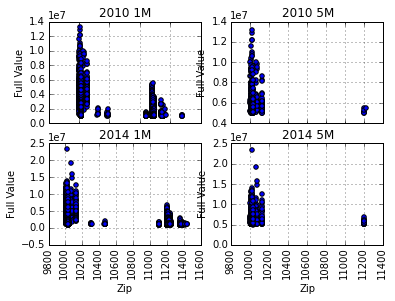

In [22]:
from matplotlib import pyplot as plt

# plot a figure containing 2x2 subplots (2010/14 x $1m/$5M)
fig, ((ax10_1M, ax10_5M), (ax14_1M, ax14_5M)) = plt.subplots(2, 2)

# 2010 subplots
df10res[df10res["Full Value"] >= 1e6].plot(
    ax=ax10_1M, y="Full Value", x="Zip", kind="scatter", title="2010 1M", rot=90)
df10res[df10res["Full Value"] >= 5e6].plot(
    ax=ax10_5M, y="Full Value", x="Zip", kind="scatter", title="2010 5M", rot=90)

# 2014 subplots
df14res[df14res["Full Value"] >= 1e6].plot(
    ax=ax14_1M, y="Full Value", x="Zip", kind="scatter", title="2014 1M", rot=90)
df14res[df14res["Full Value"] >= 5e6].plot(
    ax=ax14_5M, y="Full Value", x="Zip", kind="scatter", title="2014 5M", rot=90)

### Print sample tabular info.
# Houses > $1M; count how many in each zip code
print("\n\n2014: zip codes with most (count) houses > $1M: Park Slope area\n\n{}".format(
    df10res[df10res["Full Value"] >= 1e6].Zip.value_counts().head(5).to_string()))

# Houses > $5M; count how many in each zip code
print("\n\n2014: zip codes with most (count) houses > $5M: 10014/West Village area\n\n{}".format(
    df14res[df14res["Full Value"] >= 5e6].Zip.value_counts().head(5).to_string()))


## ===> New Query:

### Test the "Residential" column that we added.<br>(top residential vs. non-residential properties in Red Hook area.)
 

Which properties top the list in a particular zip code (11231) with/without the Residential filter applied?

*** Result below: ***
The "all properties" listing is topped by the shipping port in Red Hook and other government properties with Tax Class = 4.<br>The "residential" listings are topped along residential Clinton, Kane and Tompkins streets, right next the Synagogue :)

### Good enough filtering criterion.<br>This will allow us to do "residential-only" type of queries.

In [23]:
# Choose 11231 (Red Hook/Gowanus,/Carroll Gardens area in Brooklyn).
df10_11231 = df10[df10.Zip == 11231].sort("Full Value", ascending=False)
df14_11231 = df14[df14.Zip == 11231].sort("Full Value", ascending=False)

cols_to_print = ["FullValueUX", "Owner", "Street Address", "Tax Class"]

print("2010 top 10 values (all properties) in zip=11231\n\n{}".format(
        df10_11231[:8][cols_to_print].to_string()))
print("\n\n2010 top 10 values (residential only) in zip=11231\n\n{}".format(
        df10_11231[df10_11231.Residential==True][:8][cols_to_print].to_string()))


# let's inform engine that it can garb.collect dataframes we won't use anymore
del df10_11231
del df14_11231

2010 top 10 values (all properties) in zip=11231

         FullValueUX                  Owner       Street Address Tax Class
264568  $100,200,000     DEPT RE-CITY OF NY   118 CONOVER STREET         4
265587   $42,600,000  ONE BEARD STREET, LLC      21 BEARD STREET         4
260478   $30,600,000     BOARD OF EDUCATION     610 HENRY STREET         4
263476   $21,500,000     BOARD OF EDUCATION   242 CARROLL STREET         4
265586   $20,685,000       640 COLUMBIA LLC  640 COLUMBIA STREET         4
265591   $13,460,000  GOWANUS INDUSTRIAL PA  685 COLUMBIA STREET         4
265588   $13,371,600  THOR 280 RICHARDS STR  280 RICHARDS STREET         4
265044   $13,100,000    183 LORRAINE STREET  183 LORRAINE STREET         4


2010 top 10 values (residential only) in zip=11231

       FullValueUX                Owner      Street Address Tax Class
257693  $3,610,000  FORMAN, ELIZABETH A     249 KANE STREET         1
258481  $3,600,000   SHARON E HUMPHREYS   36 TOMPKINS PLACE         1
258517  $3,

---
## ===> New Query:
##How many residential properties changed ownership between 2010 & 2014.

###OK, here's the plan, impefect and subjective, to get at these "house changed-hands" numbers:
* We start with 2 separate datasets (DataFrames)
  - df10res: 2010 residential properties
  - df14res: 2014 residential properties
* Join these 2 dataframes to create a new one: df1014res_owners
* df1014res_owners will contain the 2 joined Owner columns: Owner_10 & Owner_14
* Normalize these Owner columns, so that "HOORNBEEK, FRANK D" is the same as "FRANK HOORNBEEK"
* Definition of a matching property (2010 vs. 2014); 
  - it's the same property in the 2 DataFrames if these cols match: 
  - "Zip" and "Street Address"
* Once we have the joined DF (df1014res_owners) then we simply compare, for each row/residence, whether the normalized Owner_10 column matches the Owner_14 column.
* The rows that are not the same represent a change in ownership.
* Later we could use this resulting DF data to perform further, more insightful queries. For example, try to identify "migratory/relocation/displacement" patterns: did sellers in a particular Zip, move en-masse, as a group, to a new "target" location; and are they part of a larger domino effect type of pattern?.
* But for now, the first step: generate the new df1014res_owners DataFrame.

***

### Start by using a smaller test/sample dataset to verify that what we are doing is correct. <br>The full dataset takes a while to compute and manipulate.<br>Also, it contains so many rows that it's difficult to see what's going on.


*** The smaller sample dataframe will consist of properties in zip-code 11231 and block 460. ***

In [24]:
df10res_sml = df10[(df10.Zip == 11231) & (df10.Block == 460) & (df10.Residential == True)]
df14res_sml = df14[(df14.Zip == 11231) & (df14.Block == 460) & (df14.Residential == True)]

## Create a joined dataframe:
# 
#  - join on (zip, addr) columns, and add the "block" and "owner" columns.
#  - we end-up with table like this...
# 
#    Index   "Zip"  "Block"  "Street Address"   "Owner_2010"   "Owner_2014"
#    -----   -----  -------  ----------------   ------------   ------------
##

# include these columns from the source DFs used to generate merged/joined DataFrame
# (Block is not needed for the small/test joined DF, but will be needed for the final DF)
cols_of_interest = ["Zip", "Block", "Street Address", "Owner"]

# do the merge: 2010 is the left side of the join (i.e. ignore new 2014 properties)
df1014res_owners = pd.merge(left=df10res_sml[cols_of_interest],
                            right=df14res_sml[cols_of_interest],
                            on=["Zip", "Street Address"],
                            how="inner",
                            suffixes=("_10", "_14"))

###Nice sample size: 49 rows/residences in this 11231/Carroll Gardens 460 block.

In [25]:
print("Shape (rows, cols) of 2010 sample DataFrame: {}".format(df10res_sml.shape))
print("Shape (rows, cols) of 2014 sample DataFrame: {}".format(df14res_sml.shape))
print("Shape (rows, cols) of joined sample DataFrame: {}".format(df1014res_owners.shape))

Shape (rows, cols) of 2010 sample DataFrame: (49, 13)
Shape (rows, cols) of 2014 sample DataFrame: (50, 13)
Shape (rows, cols) of joined sample DataFrame: (49, 6)


## Let's take a head() peek at what we got (things look good):

###Data looks right: most properties have the same owner.<br>But there's the occasional change. For example:
*** #12 on 2 Street has a new owner: "LEVY, JENNIFER" (index 3 in the last/joined dataframe) ***

In [26]:
# Let's see what we got. Compare the shape (num of props) of the 2010 vs. 2014 vs. merged DFs
print("\n2010 sample rows \n\n{}".format(df10res_sml.head(5).sort("Street Address")[["Street Address", "Owner"]].to_string()))
print("\n\n2014 sample rows \n\n{}".format(df14res_sml.head(5).sort("Street Address")[["Street Address", "Owner"]]))
print("\n\n2010/14 joined sample rows \n\n{}".format(df1014res_owners.head(5).sort("Street Address")[["Street Address", "Owner_10", "Owner_14"]]))


2010 sample rows 

       Street Address               Owner
263765    10 2 STREET  DELLE CAVE, JOSEPH
263766    12 2 STREET       JONES, ARTHUR
263767    14 2 STREET     PHILIP CASTAGNA
263763     6 2 STREET        SNOW,JAMES,R
263764     8 2 STREET         DAVID WOLIN


2014 sample rows 

       Street Address               Owner
273507    10 2 STREET  DELLE CAVE, JOSEPH
273508    12 2 STREET      LEVY, JENNIFER
184688    54 2 STREET         LLOYD JAGAI
273505     6 2 STREET        SNOW,JAMES,R
273506     8 2 STREET         DAVID WOLIN


2010/14 joined sample rows 

  Street Address            Owner_10            Owner_14
2    10 2 STREET  DELLE CAVE, JOSEPH  DELLE CAVE, JOSEPH
3    12 2 STREET       JONES, ARTHUR      LEVY, JENNIFER
4    14 2 STREET     PHILIP CASTAGNA     PHILIP CASTAGNA
0     6 2 STREET        SNOW,JAMES,R        SNOW,JAMES,R
1     8 2 STREET         DAVID WOLIN         DAVID WOLIN


## Perform the comparison to get a list of the houses w/ new owners.

### Out of the 49 houses in that block (zip=11231, block=460), we get 17 new owners.

But if we look closer at the names (Owner_10 vs. Owner_14), we see that <br>some of these rows whow up as new owners as the result of minor text differences.<br><br>For example #16 "FILOMENA PERUFFO" vs. "PERUFFO, FILOMENA".


In [27]:
naive_owner_comp = (df1014res_owners.Owner_10 != df1014res_owners.Owner_14)
df1014res_owners[naive_owner_comp][["Street Address", "Owner_10", "Owner_14"]]

,Street Address,Owner_10,Owner_14
3,12 2 STREET,"JONES, ARTHUR","LEVY, JENNIFER"
11,30 2 STREET,MESSING JEANNE E,"WALSH, FREDERICK M"
12,32 2 STREET,BRACCO ANN,"CLAUSEN, DAVID"
13,34 2 STREET,PAULY PHILIP J,"BOGART, MICHELE H"
16,40 2 STREET,FILOMENA PERUFFO,"PERUFFO, FILOMENA"
17,42 2 STREET,MALVASIO JOHN J JR,"MALVASIO, JOHN III"
18,44 2 STREET,MR LOUIS CONA,"CONA, LOUIS"
19,46 2 STREET,A DE SALVO,"DE SALVO, JEAN"
24,56 2 STREET,MURO CARMINE,MURO ANNETTE
25,58 2 STREET,ANELLO MATTEO,"FRANCESCA WENELL, TRU"


## Let's create a better name comparison.<br>Even simple compare improvements yield better results.

Create a customized string comparison func that will get applied to each <br>(row x Owner_10) and (row x Owner_14) cell.
<br><br>
Use a regex to find valid names, and remove all punctuation, extraneous spaces, etc.
<br>
Create a set() with the resulting valid names and do set() comparisone between columns.
<br><br>
For example, both strings "FILOMENA PERUFFO" and "PERUFFO, FILOMENA"
<br>
will yield the same set(): {'FILOMENA', 'PERUFFO'}.

### Create the customized compare func and apply it to re-generate the diffs.

In [28]:
import re

names_to_include = re.compile("\w{2,}")

def owner_name_cleanup(owner_str):
    return (set(names_to_include.findall(owner_str)) - 
            {"MR", "MRS", "MS", "MISS", "DR"})

improved_comp = (df1014res_owners.Owner_10.apply(owner_name_cleanup) != \
                 df1014res_owners.Owner_14.apply(owner_name_cleanup))

df1014res_owners[improved_comp][["Street Address", "Owner_10", "Owner_14"]]

,Street Address,Owner_10,Owner_14
3,12 2 STREET,"JONES, ARTHUR","LEVY, JENNIFER"
11,30 2 STREET,MESSING JEANNE E,"WALSH, FREDERICK M"
12,32 2 STREET,BRACCO ANN,"CLAUSEN, DAVID"
13,34 2 STREET,PAULY PHILIP J,"BOGART, MICHELE H"
17,42 2 STREET,MALVASIO JOHN J JR,"MALVASIO, JOHN III"
19,46 2 STREET,A DE SALVO,"DE SALVO, JEAN"
24,56 2 STREET,MURO CARMINE,MURO ANNETTE
25,58 2 STREET,ANELLO MATTEO,"FRANCESCA WENELL, TRU"
27,62 2 STREET,"DEGN, DEIDRA","HOANG, MIMI"
31,43 3 STREET,ODETTE ROLSETH,"BEL, MARIA JOSE"


## Good enough for government work.

### Let's generate the full-set/city-wide joined table.

In [29]:
# some cleanup: done with small/test subsets
del df10res_sml
del df14res_sml

# and a reminder of the full dataset shapes (around 400k rows about to be merged)
(df10res.shape, df14res.shape)

((427471, 13), (428665, 13))

In [30]:
# do the full merge: 2010 is the left side of the join (i.e. ignore new 2014 properties)
cols_of_interest = {"Zip", "Block", "Street Address", "Owner"}
df1014res_owners = pd.merge(left=df10res[list(cols_of_interest)],
                            right=df14res[list(cols_of_interest - {"Block"})],
                            on=["Zip", "Street Address"],
                            how="inner",
                            suffixes=("_10", "_14"))

In [31]:
# what do have? looks ok, most of the left/2010 (zip, addrs) were inner-merged successfully
print(df1014res_owners.shape)

(424426, 5)


### A quick validation of the merge.

Out of the full merge, display the slice corresponding to the zip/block (11231/460)<br>
that we used above and that we are familiar with.<br>
Make sure we still see the same data.

In [32]:
# cool: still 49 merged entries
print(df1014res_owners[(df1014res_owners.Zip == 11231) & 
                       (df1014res_owners.Block == 460)].shape)

# and, the usual suspects
df1014res_owners[(df1014res_owners.Zip == 11231) & 
                 (df1014res_owners.Block == 460)].head()[["Zip", "Street Address", "Owner_10", "Owner_14"]]

(49, 5)


,Zip,Street Address,Owner_10,Owner_14
54722,11231,6 2 STREET,"SNOW,JAMES,R","SNOW,JAMES,R"
54723,11231,8 2 STREET,DAVID WOLIN,DAVID WOLIN
54724,11231,10 2 STREET,"DELLE CAVE, JOSEPH","DELLE CAVE, JOSEPH"
54725,11231,12 2 STREET,"JONES, ARTHUR","LEVY, JENNIFER"
54726,11231,14 2 STREET,PHILIP CASTAGNA,PHILIP CASTAGNA


## And finally, generate the full table containing all residences<br>that had a change of ownership from 2010 vs. 2014.

In [33]:
##############  reminder of what the compare util looks like
import re

names_to_include = re.compile("\w{2,}")
def owner_name_cleanup(owner_str):
    return (set(names_to_include.findall(owner_str)) - 
            {"MR", "MRS", "MS", "MISS", "DR"})

improved_comp = (df1014res_owners.Owner_10.apply(owner_name_cleanup) != \
                 df1014res_owners.Owner_14.apply(owner_name_cleanup))
###########  reminder of what the compare util looks like

df1014res_owner_change = df1014res_owners[improved_comp]

In [34]:
print("From 2010 to 2014, {:,} residences have new owners (out of {:,} total).".format(
        df1014res_owner_change.shape[0], df1014res_owners.shape[0]))

From 2010 to 2014, 110,467 residences have new owners (out of 424,426 total).


## Playing with Pandas: various ways to group, slice, view the data...

### In general, lots of ownership turnover in Southern Brooklyn.

### And what's with zip code 11234, a far-away outlier?

Indeed, in the news recently...<br>
http://www.thejewishweek.com/news/new-york/orthodox-influx-remaking-marine-park

In [35]:
# index and sort by zip...
df1014res_owner_change_ixzip = df1014res_owner_change.set_index("Zip").sort_index()
print(df1014res_owner_change_ixzip.head()[["Street Address", "Owner_10", "Owner_14"]])
print()

# groupby zip
grpbyzip_own_change = df1014res_owner_change.groupby("Zip")
print(grpbyzip_own_change.size().order(ascending=False).head(8))
print()

# groupby (zip, block)
grpbyzipblk_own_change = df1014res_owner_change.groupby(["Zip", "Block"])
print(grpbyzipblk_own_change.size().order(ascending=False).head(8))

            Street Address               Owner_10               Owner_14
Zip                                                                     
10001   450 WEST 25 STREET     AMARGER, CHRISTINE   450 WEST 25TH STREET
10001   351 WEST 30 STREET           MOORE, PETER  NOEL BLAIR AS CO-TRUS
10002  246 ELDRIDGE STREET  THE ROBERT CROZIER RE  ROBERT CROZIER AS TRU
10002   85 DIVISION STREET  INTER LOYAL PROPERTIE    TAN-TAN ENTERP INC
10002    88 CLINTON STREET  WILLIAM GOTTLIEB REAL         88 CLINTON LLC

Zip
11234    3486
11385    2474
11229    2319
11236    2226
11223    2053
11204    1962
11214    1921
11379    1877
dtype: int64

Zip    Block
11229  7405     123
11235  7422      96
10463  5909      93
11235  7441      86
10306  4478      83
11214  6461      77
10309  7596      70
10304  2925      66
dtype: int64


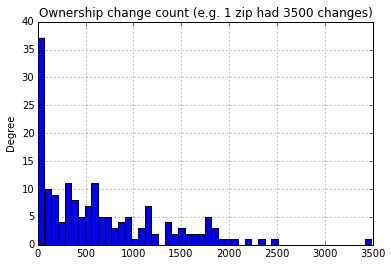

In [36]:
# histogram...
grpbyzip_own_change.size().order(
    ascending=False).iloc[:].plot(kind="hist", 
                                  bins=50,
                                  title="Ownership change count (e.g. 1 zip had 3500 changes)")
                                                                

## So, that count of 3486 ownership change in 11234 seems high. But we have no idea relative to what total number of properties in that zip code.

### All these house ownership change totals per zip are more meaningful<br>if the cnt figure is relative to the total number of properties in the zip<br>(percent ownership change per zip).

###Let's calculate the highest percent change zip codes.

In [37]:
# We already have the series with the ownership change count:
print("\n\n", 40*"*")
print("Series shape for ownership change count per zip: \n{}".format(
        grpbyzip_own_change.size().shape))
print()
print("Series sample for ownership change count per zip: \n{}".format(
            grpbyzip_own_change.size().ix[11234:11237]))


# Let's create another Series, containing the total count of residential props per zip.
series_tot_zipcnt = df10res.groupby("Zip").size()
print("\n\n", 40*"*")
print("Series shape for total properties count per zip: \n{}".format(
        series_tot_zipcnt.shape))
print()
print("Series sample for total properties count per zip: \n{}".format(
            series_tot_zipcnt.ix[11234:11237]))



 ****************************************
Series shape for ownership change count per zip: 
(167,)

Series sample for ownership change count per zip: 
Zip
11234    3486
11235    1386
11236    2226
11237     335
dtype: int64


 ****************************************
Series shape for total properties count per zip: 
(172,)

Series sample for total properties count per zip: 
Zip
11234    14643
11235     5031
11236    11371
11237     1530
dtype: int64


## Ok the numbers above look correct (11234 zip code: total=14643, change=3486).

###Also, it looks like 5 zips (172 - 167) did not have any changes in the 2010->2015 time-span.

### Let's put the 2 series (total, change) as side-by-side columns a single DataFrame.

In [40]:
zip_cmp_series = {"total_zip_cnt": series_tot_zipcnt,
                  "change_zip_cnt": grpbyzip_own_change.size()}

zip_cmp = pd.DataFrame(zip_cmp_series)

## and confirm that the DF looks right...
print("\n\n", 40*"*")
print("DataFrame shape (tot vs. change) per zip: \n{}".format(
       zip_cmp.shape))
print()
print("DataFrame sample (tot vs. change) per zip: \n{}".format(
       zip_cmp.ix[11234:11237]))



 ****************************************
DataFrame shape (tot vs. change) per zip: 
(172, 2)

DataFrame sample (tot vs. change) per zip: 
       change_zip_cnt  total_zip_cnt
Zip                                 
11234            3486          14643
11235            1386           5031
11236            2226          11371
11237             335           1530


In [41]:
pct_change = (dzip_cmp.change_zip_cnt * 100) / dzip_cmp.tot_zip_cnt
print("Percent change for each zip (Series) - shape: \n", pct_change.shape)
pct_change.dropna(inplace=True)
print("After dropping NaN rows: \n", pct_change.shape)
pct_change.order(ascending=False, inplace=True)

# let's make sure the calculation was setup correctly
# saul good,man
print("\nSpot checking: zip 11234...")
print(dzip_cmp.ix[11234:11236]) # reminder of the 11234 vals
print("\nComputed vs. manually check % change for 11234 -> all good")
print(pct_change[11234])
print("manual: ", 3486*100/14627)

# 100% turnover!
# yep, 1 prop in that zip will do it
print("\nhead() -> zips with top % values -> 100% ?!")
print(pct_change.head())
print("\nHow many props in this 10038 zip? ", series_tot_zipcnt[10038])


NameError: name 'dzip_cmp' is not defined

In [42]:
# lt's put an arbitrary inclusion limit:
# only consider zips with 50+ props
print("Let's exclude zips with few number of properties...")
print("pre cut:", series_tot_zipcnt.shape)
series_tot_zipcnt = series_tot_zipcnt[series_tot_zipcnt >= 50]
print("post cut:", series_tot_zipcnt.shape)

Let's exclude zips with few number of properties...
pre cut: (172,)
post cut: (150,)


In [43]:
# re-create the compare DataFrame...
df_zip_cmp = pd.DataFrame(index=series_tot_zipcnt.index)
df_zip_cmp["total_zip_cnt"] = series_tot_zipcnt
df_zip_cmp["change_zip_cnt"] = grpbyzip_own_change.size()


# and, re-create percent change calculations...
pct_change = (df_zip_cmp.change_zip_cnt * 100) / df_zip_cmp.total_zip_cnt
pct_change.order(ascending=False, inplace=True)

print("Try again: head() -> zips with top % values: \n")
print(pct_change.head())

print()
print("Let's add the pct change Series as a column to the compare DataFrame")
df_zip_cmp["pct_change"] = pct_change
print("Spot check our well known 11234 zip -> looks good.")
df_zip_cmp.ix[11234:11236]

Try again: head() -> zips with top % values: 

Zip
10021    42.187500
10024    37.398374
10014    33.935743
10463    33.614331
10025    33.027523
dtype: float64

Let's add the pct change Series as a column to the compare DataFrame
Spot check our well known 11234 zip -> looks good.


,total_zip_cnt,change_zip_cnt,pct_change
Zip,,,
11234,14643,3486,23.806597
11235,5031,1386,27.549195
11236,11371,2226,19.576115


## Quick stats...

In [44]:
df_zip_cmp.describe()

,total_zip_cnt,change_zip_cnt,pct_change
count,150.000000,150.000000,150.000000
mean,2843.846667,728.766667,25.851083
std,2577.084279,647.742392,3.678283
min,54.000000,12.000000,14.117647
25%,797.500000,202.750000,23.511590
50%,2251.500000,563.500000,25.913994
75%,4214.750000,1134.500000,27.729724
max,14643.000000,3486.000000,42.187500


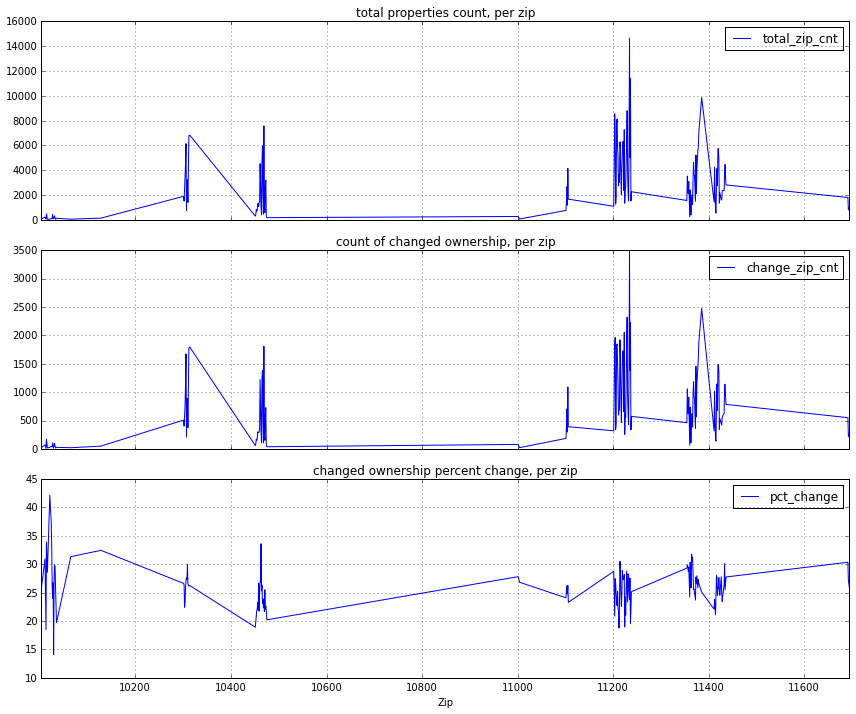

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=1)

#fig.figsize=(100,100)

df_zip_cmp.plot(ax=axes[0], y=["total_zip_cnt"], 
                title="total properties count, per zip")
df_zip_cmp.plot(ax=axes[1], y=["change_zip_cnt"], 
                title="count of changed ownership, per zip", figsize=(12,10))
df_zip_cmp.plot(ax=axes[2], y=["pct_change"], 
                title="changed ownership percent change, per zip")
fig.tight_layout()

## work-in-progress below...<br>work-in-progress below...<br>work-in-progress below...

---

## ===> New Query:

### Top 10 valued residential properties, NYC-wide?

2010's #2 rises to the top in 2014, almost doubling in value. Facing the East River:<br>
http://www.nytimes.com/2008/05/25/realestate/25deal1.html

In [46]:
print("2010 top 10 values (all properties) city-wide\n\n{}".format(
        df10res.sort("Full Value", ascending=False)[:5][cols_to_print]))

print("\n\n2014 top 10 values (all properties) city-wide\n\n{}".format(
        df14res.sort("Full Value", ascending=False)[:5][cols_to_print]))

2010 top 10 values (all properties) city-wide

       FullValueUX                 Owner         Street Address Tax Class
98611  $13,200,000           USDAN, ADAM     161 EAST 73 STREET         1
94452  $12,900,000  7 SUTTON SQUARE, LLC        7 SUTTON SQUARE         1
68546  $12,200,000         JANN S WENNER      27 WEST 74 STREET         1
31551  $12,200,000        SACKHEIM, CARL  689 WASHINGTON STREET         1
41583  $11,600,000      859 BROADWAY LLC           859 BROADWAY         1


2014 top 10 values (all properties) city-wide

        FullValueUX                 Owner      Street Address Tax Class
100511  $23,374,000  7 SUTTON SQUARE, LLC     7 SUTTON SQUARE         1
103958  $19,055,000  126 EAST 66TH STREET  126 EAST 66 STREET         1
102779  $15,822,000             CKLM, LLC     870 PARK AVENUE         1
102776  $14,848,000     A. ALEXANDER LARI   75 EAST 77 STREET         1
32610   $14,000,000      RESNICK, SCOTT N   293 WEST 4 STREET         1


---
## ===> New Query:
### Who owns the most housing real estate?<br>Deutschland not just powerful at soccer.<br>However, 2014 numbers seems to indicate that banks finally cleared their recession inventory.

In [47]:
print("2010 top residential owners: \n{}".format(df10res.Owner.value_counts().head(10).to_string()))
print("\n", 40*"*", "\n")
print("2014 top residential owners: \n{}".format(df14res.Owner.value_counts().head(10).to_string()))

2010 top residential owners: 
                         2456
DEUTSCHE BANK NATIONA     299
NEW YORK CITY HOUSING     196
U.S. BANK NATIONAL AS     113
WELLS FARGO BANK, N.A      91
HSBC BANK USA, NATION      72
HOUSING PRESERVATION       66
FEDERAL NATIONAL MORT      60
SECRETARY OF HOUSING       56
NYC PARTNERSHIP HOUSI      54

 **************************************** 

2014 top residential owners: 
                         1196
NEW YORK CITY HOUSING     194
OWNER / AGENT             152
RESTORING URBAN NEIGH      50
HOUSING PRESERVATION       48
DEUTSCHE BANK NATIONA      47
NYC HOUSING AUTHORITY      44
NEHEMIAH HOUSING DEVE      34
NYC PARTNERSHIP HOUSI      27
CITY OF NEW YORK           26


---
## ===> New Query:

### Characterize 2010 vs. 2014 difference in the count of properties in the datasets.<br>(e.g. are the new properties in 2014 concentrated in a particular geo/area?)

*** Conclusion: it's a hipsters' zipster ***

zip code 11249:<br>
https://goo.gl/maps/E8bwJ<br>
http://www.brooklynpaper.com/stories/34/23/wb_zipcodechange_2011_06_10_bk.html


In [48]:
zip10 = {int(xx) for xx in df10.Zip.value_counts().keys()}
zip14 = {int(xx) for xx in df14.Zip.value_counts().keys()}

zipdiff_in14 = zip14 - zip10
zipdiff_in10 = zip10 - zip14
print()
print("Zips in 2014, but not in 2010: \n", zipdiff_in14)
print()
print("Zips in 2010, but not in 2014: \n", zipdiff_in10)
print()
print("Number of new properties in the new 2014 zips: {}".format(
        df14[df14.Zip.isin(zipdiff_in14)].shape[0]))

print("\n\n")
df10zipgrp = df14[df14.Zip.isin(zipdiff_in14)].groupby("Zip")
print("Distribution of new 2015 properties: \n\n{}\n".format(
        df10zipgrp.size().order(ascending=False).to_string()))

print("Zip 11249? It's zipster-land: https://goo.gl/maps/E8bwJ")

# mem dealloc...
del df10zipgrp
del zipdiff_in10
del zipdiff_in14


Zips in 2014, but not in 2010: 
 {10112, 10119, 11241, 11242, 10123, 10129, 10162, 11249, 10103}

Zips in 2010, but not in 2014: 
 {11352, 11021}

Number of new properties in the new 2014 zips: 5924



Distribution of new 2015 properties: 

Zip
11249    5783
10112     110
10129      17
10103       6
10119       3
11242       2
11241       1
10162       1
10123       1

Zip 11249? It's zipster-land: https://goo.gl/maps/E8bwJ


---
## ===> New Query:

###Learn about Pandas' DataFrame.unstack() feature.<br><br>Group dataframe by zip codes.<br>Then create square-ft buckets in 1000.ft increments.<br>[ (0-999), (1k-2k), (2k-3k), ... )<br>Then figure out mean, max, ... prop. values for the various sq.ft buckets in each zip code.

***Note: this cell creates the (zip, sq.ft) groupings. The next cell uses them to do some queries.***

****************************************
***** Sq.Ft analysis for year 2010 *****


Reminder: total number or properties in dataset: 1,060,512
Unique Sq.Ft values: 18,708


Drop unreasonably low/high square footage values (0, incorrect, unrepresentative)
Explore quantiles (e.g. find first (> 500) and (< 12k) sqft) properties.
...Looking for lower quantile value -> @ quant=0.1, sq.ft=0.0
...Looking for lower quantile value -> @ quant=0.11, sq.ft=0.0
...Looking for lower quantile value -> @ quant=0.12, sq.ft=0.0
...Looking for lower quantile value -> @ quant=0.13, sq.ft=0.0
...Looking for lower quantile value -> @ quant=0.14, sq.ft=0.0
...Looking for lower quantile value -> @ quant=0.15, sq.ft=640.0
-> Found lower quantile value: 0.16 -> sq.ft=640.0

...Looking for upper quantile value -> @ quant=0.99, sq.ft=29587.80000000028
...Looking for upper quantile value -> @ quant=0.98, sq.ft=20000.0
...Looking for upper quantile value -> @ quant=0.97, sq.ft=15000.0
...Looking for upper quantile 

/home/jds/.pyvenvs/liveresume/lib/python3.4/site-packages/IPython/kernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


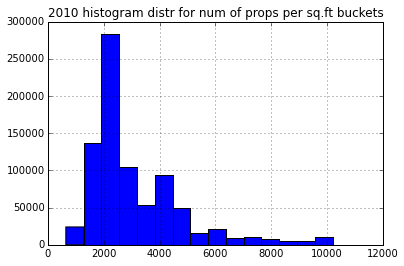

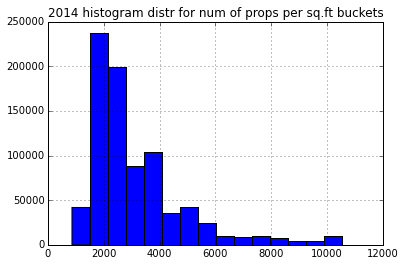

In [49]:
for dfinfo in _subdfs():
    print("*"*40)
    print("***** Sq.Ft analysis for year {} *****".format(dfinfo.year))
    print("\n")

    df = dfinfo.dfsub
    print("Reminder: total number or properties in dataset: {:,}".format(df.shape[0]))
    print("Unique Sq.Ft values: {:,}".format(len(df.SquareFt.unique())))


    ##### start of finding lower/upper bounds
    print("\n")
    print("Drop unreasonably low/high square footage values (0, incorrect, unrepresentative)")
    print("Explore quantiles (e.g. find first (> 500) and (< 12k) sqft) properties.")
    MIN_TARGET_SQFT, MAX_TARGET_SQFT = (500, 12000)
    QUANTILE_DELTA_STEP = 0.01

    # find min/lower bound quantile value 
    min_sq_ft = 0.10
    current_sq_ft = df.SquareFt.quantile(min_sq_ft)
    while current_sq_ft < MIN_TARGET_SQFT:
        min_sq_ft += QUANTILE_DELTA_STEP
        current_sq_ft = df.SquareFt.quantile(min_sq_ft)
        print("...Looking for lower quantile value -> @ quant={:.2}, sq.ft={}".format(
            min_sq_ft-QUANTILE_DELTA_STEP, current_sq_ft))
    print("-> Found lower quantile value: {:.2} -> sq.ft={}\n".format(
        min_sq_ft, current_sq_ft))

    # find max/upper bound quantile value 
    max_sq_ft = 0.99
    current_sq_ft = df.SquareFt.quantile(max_sq_ft)
    while current_sq_ft > MAX_TARGET_SQFT:
        max_sq_ft -= QUANTILE_DELTA_STEP
        current_sq_ft = df.SquareFt.quantile(max_sq_ft)
        print("...Looking for upper quantile value -> @ quant={:.2}, sq.ft={}".format(
            max_sq_ft+QUANTILE_DELTA_STEP, current_sq_ft))
    print("-> Found upper quantile value: {:.2} -> sq.ft={}\n".format(
        max_sq_ft, current_sq_ft))

    print("Use the ({:.2} -> {:.2}) range. Create subset dataframe with just these rows".format(
        min_sq_ft, max_sq_ft))
    
    df_sqft = df[(df.SquareFt >= df.SquareFt.quantile(min_sq_ft)) &
                 (df.SquareFt <= df.SquareFt.quantile(max_sq_ft))]

    print()
    print("Comparison of number of rows in full vs. f(sqft reduced) datasets")
    print("Num rows: full: {:,} vs. drop sq.ft tails: {:,}".format(
        df.SquareFt.shape[0], df_sqft.SquareFt.shape[0]))


    print()
    print("Add a column that classifies each property's sq.ftage into a more coarse per-1000 SqFt bucket.")
    df_sqft["sf1000"] = (df_sqft.SquareFt // 1000 * 1000)
    print("Overall dataset has {} sq.ft/1000s buckets".format(
        len(df_sqft.sf1000.unique())))


    print()
    print("Visualize where these sq. ft buckets lie (see histogram at the bottom of the cell)")
    from matplotlib import pyplot as plt
    fig = plt.figure()
    #ax = df_sqft.sf1000.hist(bins=15)
    ax = df_sqft.SquareFt.hist(bins=15)
    ax.set_title("{} histogram distr for num of props per sq.ft buckets".format(
        dfinfo.year))
    
    ### yeah, finally get to learn about and use the "unstack"
    ### see examples in subsequent cells
    print()
    print("And now, create some groups that contain the median/max assessed values\n"
          "for each per-zip, per-1000 sq.ft bucket. We'll use these groupings in the next cells.")
    dfgrp_sqf_median = df_sqft.groupby(["Zip", "sf1000"]).median()[["Full Value"]].unstack("sf1000")
    dfgrp_sqf_max = df_sqft.groupby(["Zip", "sf1000"]).max()[["Full Value"]].unstack("sf1000")
    
    # save them in the global datasets info
    datasets_info[dfinfo.year]["dfgrp_sqf_median"] = dfgrp_sqf_median
    datasets_info[dfinfo.year]["dfgrp_sqf_max"] = dfgrp_sqf_max

    
    # indicate non-further use of references to large blocks of mem
    del df
    del df_sqft
    del dfgrp_sqf_max
    del dfgrp_sqf_median
    
    print("\n"*3)

### Ok, now let's make use of the "unstacked" data;<br>Do some queries with the median and max property groupings per (zip, sq-ft) extracted above.

In [50]:
# short cuts: 2010 max and mean groupby dataframes
df10grp_sqf_max = datasets_info[2010]["dfgrp_sqf_max"]
df10grp_sqf_median = datasets_info[2010]["dfgrp_sqf_median"]

# 2014
df14grp_sqf_max = datasets_info[2014]["dfgrp_sqf_max"]
df14grp_sqf_median = datasets_info[2014]["dfgrp_sqf_median"]

### What does the unstacked table look like?<br>Zip code per row, sq.ft buckets per column.

In [51]:
### the applymap formatting does not play well with github's rendering; KISS
#df14grp_sqf_max.head().applymap("${:,.0f}".format)
df14grp_sqf_max.head()

Full Value                                                              \
sf1000      0         1000      2000      3000      4000      5000      6000    
Zip                                                                             
10001     5980000  12479000  27165000  28690000  47844000  66944000  63366000   
10002     3589000   6194000  11419000   7956000   9040000  34895000  16111868   
10003     6301000  14157000  36100000  18561000  22980000  29212000  39470000   
10004     1208000   4491000  11450000   6356000   5318549       NaN   5222000   
10005     2687000  14100000  25989000  13422000  30233000       NaN  48347000   

                                                 
sf1000      7000      8000      9000      10000  
Zip                                              
10001   124513000  52491000  67270000  67106000  
10002    24881000  11620000   7258000   6228000  
10003    34457000  25339000  99965000  29395000  
10004    14335000  57470000         0  40369000  
10005    19259000  36554000       NaN  18848000

---
## ===> New Query:
### Given a range of zip codes, display values per 1000 square-feet buckets<br>(since it's indexed by zip, easy to compare values per zip code)

In [52]:
# since it's indexed by zip, easy to compare values per zip code

## Park Slope: concat median and max rows
ps_zips = list(range(11215, 11218))

concat_indices = ["{} - {}".format(op, zip)
                  for op in ["max", "median"] 
                  for zip in ps_zips]

concat_df = pd.concat([df14grp_sqf_max.ix[ps_zips], df14grp_sqf_median.ix[ps_zips]])
concat_df.index = concat_indices

### the applymap formatting does not play well with github's rendering; KISS
#concat_df.applymap("${:,.0f}".format)
concat_df

Full Value                                               \
sf1000              0        1000     2000     3000     4000     5000    
max - 11215       1436000  4689000  4990000  6215000  4305000  6380000   
max - 11216        667000  1452000  4473000  3224000  2599000  2252000   
max - 11217       1711000  4097000  3649000  3306000  4394000  4721000   
median - 11215     583500  1140000  1245000  1146500   636000    52933   
median - 11216     421000   513000   588000   640000   464000   559000   
median - 11217     793000  1241000  1412500   351702   436452   439630   

                                                                
sf1000            6000      7000      8000      9000     10000  
max - 11215     7885000   7940000   6044000   7810000  7755000  
max - 11216     6028000  16311000  13138000   6532000  2793000  
max - 11217     6126000   5711000  10598000  19155000  5394000  
median - 11215   547670     95589     94166   1658000  1095000  
median - 11216   613868    774500   1040000    934000   882500  
median - 11217   215000    903839   1049257   1018355   870000

In [53]:
# specific zips - top
zips = [10022, 10014, 11215]

### the applymap formatting does not play well with github's rendering; KISS
#pd.concat([df14grp_sqf_max.ix[zips], df14grp_sqf_median.ix[zips]]).applymap("${:,.0f}".format)
pd.concat([df14grp_sqf_max.ix[zips], df14grp_sqf_median.ix[zips]])

Full Value                                                     \
sf1000      0         1000      2000      3000      4000       5000    
Zip                                                                    
10022     5780000  23374000  52506000  40649000  46363000  374000000   
10014     8722000  12700000  16564000  14510000  16324000   49577000   
11215     1436000   4689000   4990000   6215000   4305000    6380000   
10022     1746000   2302000   2450000   3041000   2510500    5802000   
10014     3325000   3681000   2135000   2715000   3052000    3713500   
11215      583500   1140000   1245000   1146500    636000      52933   

                                                           
sf1000     6000      7000       8000      9000      10000  
Zip                                                        
10022   75398000  85931000  109290000  96058000  69261000  
10014   21731000  14477000   87125000  19582687  17871000  
11215    7885000   7940000    6044000   7810000   7755000  
10022     214621    157793   15106500    156481  11459000  
10014    1187076   5939000    3050000    112714   4279000  
11215     547670     95589      94166   1658000   1095000

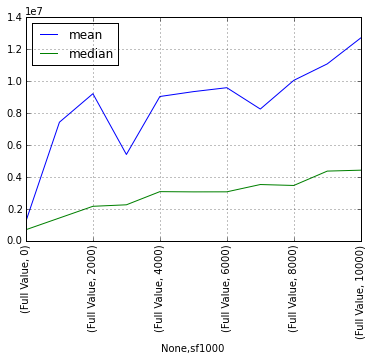

In [54]:
# high std dev
df14grp_sqf_max.apply(np.mean).plot(rot=90, label="mean")
df14grp_sqf_max.apply(np.median).plot(rot=90, label="median")

plt.legend(loc="best")

In [55]:
# let's apply various stats to each col (1000's sq.ft bucket)
ops = (min, max, np.mean, np.median, np.std)

for op in ops:
    print(40*"*", "\n\n'{}' value (city-wide) for each Sq.Ft x 1000s bucket:\n{}\n".\
          format(op.__name__, df14grp_sqf_max.apply(op).map("${:,.0f}".format)))

**************************************** 

'min' value (city-wide) for each Sq.Ft x 1000s bucket:
            sf1000
Full Value  0           $6,000
            1000      $418,000
            2000       $85,000
            3000      $437,000
            4000      $173,224
            5000      $458,000
            6000      $231,075
            7000            $0
            8000      $404,000
            9000            $0
            10000     $450,000
dtype: object

**************************************** 

'max' value (city-wide) for each Sq.Ft x 1000s bucket:
            sf1000
Full Value  0           $9,429,000
            1000      $176,422,000
            2000      $317,379,000
            3000       $86,741,000
            4000      $310,000,000
            5000      $374,000,000
            6000      $145,830,533
            7000      $124,513,000
            8000      $115,555,555
            9000      $105,498,000
            10000     $277,777,777
dtype: object

**********

In [56]:
# done with sq.ft scenarios; some mem dealloc cleanup...
del df10grp_sqf_max
del df14grp_sqf_max
del df10grp_sqf_median
del df14grp_sqf_median

# Del one more reference to sqft data, from the per-year master datasets.
for dset in datasets_info.values():
    del dset["dfgrp_sqf_median"]
    del dset["dfgrp_sqf_max"]

#  !!!! work-in-progress below !!!!<br>!!!! work-in-progress below !!!!<br>!!!! work-in-progress below !!!!<br>

---
## ===> New Query:
### Given a zip code, top valued residential properties in each of its blocks.

---
## ===> New Query:
### Majority owners of residential properties. Zip ranges, city-wide. 

---
## ===> New Query:
### Top valued properties in city, zip-range, blocks within a zip code? 

---
## ===> New Query:
###Property counts: zips with most/least residential properties.

---
## ===> New Query:
###2010 vs. 2014: are there some obvious relocation patterns?<br>(e.g. group of residents in one zip-code moved "together" to a new/same area?)

In [58]:
####################### In progress: potential queries...

#df14_ixzb.ix[11231, 464].plot(x="SquareFt", y="Full Value", kind="scatter")


#df10_res_1123x_grp_zb.apply(lambda df: df.sort_index(by="Full Value", ascending=False)[:2])[["FullValueUX", "Owner", "Street Address"]]


#hzb_grp["Full Value"].mean().plot(rot=90, style="x")

#df10_sqft1000s.groupby(["Zip", "SquareFt"]).median()[["Full Value"]].unstack("SquareFt").ix[11231].plot(rot=90)
#df10_sqft1000s.groupby(["Zip", "SquareFt"]).median()[["Full Value"]].unstack("SquareFt").ix[11231].index

#df10_sqft1000s.groupby(["Zip", "SquareFt"]).median()[["Full Value"]].unstack("SquareFt")[11230:11235]


# python client for enigma.io API - for now it just provides "export" support

In [59]:
#!/usr/bin/env python

###########
##
##  Invoke like this:
##     ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2010
##     
##     (Note: The "export" request will keep on polling the file's URL location until
##            it becomes available, or until the max number of poll retries is reached.
##            Therefore, it's normal to see a sequence of polling msgs indicating that
##            the file was still not available.)
##     
##########


import os
import sys
import time
import argparse
import requests
from requests import RequestException

ARGPARSER = argparse.ArgumentParser()
ARGPARSER.add_argument("datapath")
ARGPARSER.add_argument("-o", "--outfname", dest="outfname", required=False)


class EnigmaClient:
    ENIG_RETCODE_SUCCESS = 0
    ENIG_RETCODE_TIMEOUT = 1
    ENIG_RETCODE_ERROR   = 2

    _QUERY_TEMPLATE = "https://api.enigma.io/v2/{op}/{key}/{datapath}/{params}"
    _EXPORTAPI_MAX_SECS_TIMEOUT = 120
    _EXPORTAPI_POLL_SECS_INTERVAL = 3
    _EXPORTAPI_CHUNK_SIZE = 1024 * 64

    def __init__(self, apikey):
        self.apikey = apikey


    # To do: allow multiple, parallel exports
    #        (e.g. concurrent.futures.ThreadPoolExecutor)
    def parallel_exports(self, datapaths, parameters=None,
                         max_secs_timeout=None, outfnames=None):
        ...

                
    # Tables are exported as Gzipped CSV files. 
    # 
    # Exports of large tables may take some time, so exports are processed
    # asynchronously.
    # 
    # When the export API is called, an export is queued and the API immediately
    # returns a URL pointing to the future location of the exported file. Users
    # should poll the URL until the file becomes available.
    # 
    # Note: this is a synchronous call. Caller waits (up to max_secs_timeout)
    #       until data is made available by Enigma backend, and then downloaded.
    #       Caller should check err_code if the export fails.
    # 
    # Returns one of: ENIG_RETCODE_SUCCESS, ENIG_RETCODE_TIMEOUT, ENIG_RETCODE_ERROR
    # 
    def export(self, datapath, parameters=None,
               max_secs_timeout=None, outfname=None):

        query_str = self._QUERY_TEMPLATE.format(op="export", key=self.apikey,
                                                datapath=datapath, params="")
        # make a query, which sends back the URL that we'll have to poll
        # until it eventually responds back with the gzipped csv file.
        resp = requests.get(query_str)
        resp_json = resp.json()
        export_url = resp_json["export_url"]

        if not outfname:
            # derive it from the URL
            outfname = export_url[export_url.strip("/").rfind("/")+1:]
            if "?" in outfname:
                outfname = outfname[:outfname.rfind("?")]

        return self._download_file(export_url, outfname)
        
    def _download_file(self, export_url, outfname):
        timeout_secs_remaining = self._EXPORTAPI_MAX_SECS_TIMEOUT
        poll_time_interval = self._EXPORTAPI_POLL_SECS_INTERVAL

        completed = False
        print("About to attempt downloading export URL: {}".format(export_url))
        while (not completed) and (timeout_secs_remaining > 0):
            print("\n***Retries timeout remaining: {} secs".format(timeout_secs_remaining))
            try:
                resp = requests.get(export_url, stream=True)
                if resp.ok is True:
                    print("\nFile ready - writing to local storage.")
                    with open(outfname, 'wb') as fout:
                        for chunk in resp.iter_content(
                                chunk_size=self._EXPORTAPI_CHUNK_SIZE): 
                            if chunk: # filter out keep-alive new chunks
                                fout.write(chunk)
                                fout.flush()
                    completed = True
                else:
                    print("File not ready yet - still polling."
                          "\n  Response status_code: {} - Reason: {}".format(
                        resp.status_code, resp.reason))
            except Exception as exc:
                print("exc: {}".format(exc))
            finally:
                if not completed:
                    time.sleep(poll_time_interval)
                    timeout_secs_remaining -= poll_time_interval

        if completed is True:
            return self.ENIG_RETCODE_SUCCESS
        elif timeout_secs_remaining < 0:
            return self.ENIG_RETCODE_TIMEOUT
        else:
            return self.ENIG_RETCODE_ERROR

        
def main(apikey, args):
    client = EnigmaClient(apikey)
    client.export(args.datapath, outfname=args.outfname)


if __name__ == "__main__":
    apikey = os.getenv("ENV_ENIGMA_APIKEY")
    if not apikey:
        print('Please set your env var "ENV_ENIGMA_APIKEY"')
        sys.exit(1)
    
    main(apikey, ARGPARSER.parse_args())


Please set your env var "ENV_ENIGMA_APIKEY"


SystemExit: 1

To exit: use 'exit', 'quit', or Ctrl-D.
